In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlopen
import json
from sodapy import Socrata
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from country_list import countries_for_language
import unidecode
plt.style.use('https://raw.githubusercontent.com/datatrooper/instatrooper/master/styles/bluetrooper.mplstyle')
dp = [
    "#1c1c3c",
    "#967B4F",
    "#46493D",
    "#839DA5",
    "#9FADAD",
    "#2B4144",
    "#986E37"
]
plt.rcParams['axes.grid'] = False

In [31]:
def load_colombia_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("gt2j-8ykr", limit=100000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [32]:
df_col = load_colombia_df()

In [33]:
def preprocess_df(df):
    df = df.rename(columns={"fecha_diagnostico": "Fecha de diagnóstico",
                            "ciudad_de_ubicaci_n": "ciudad",
                            "fecha_de_notificaci_n": "Fecha de notificacion",
                            "atenci_n": "atencion"})
    
    df["sexo"] = df["sexo"].str.upper()
    df["estado"] = df["estado"].str.upper()
    df["atencion"] = df["atencion"].str.upper()
    df["tipo"] = df["tipo"].str.upper()
    df["edad"] = df["edad"].astype(int)
    
    df["Fecha de diagnóstico"] = pd.to_datetime(df["Fecha de diagnóstico"], errors="coerce")
    df["fecha_recuperado"] = pd.to_datetime(df["fecha_recuperado"], errors="coerce")
    df["fecha_de_muerte"] = pd.to_datetime(df["fecha_de_muerte"], errors="coerce")
    df.loc[df["fis"]=="Asintomático", "estado"] = "ASINTOMATICO"
    df["fis"] = pd.to_datetime(df["fis"], errors="coerce")
    df["tiempo recuperacion"] = df["fecha_recuperado"] - df["fis"]
    df["tiempo recuperacion"] = df["tiempo recuperacion"].dt.days
    
    df["tiempo muerte"] = df["fecha_de_muerte"] - df["fis"]
    df["tiempo muerte"] = df["tiempo muerte"].dt.days
    return df

In [34]:
df_col = preprocess_df(df_col)

In [35]:
df_muertos = df_col[df_col["estado"] == "FALLECIDO"]
muertos_age = df_muertos.groupby(pd.cut(df_muertos["edad"], np.arange(0, 110, 10))).size().to_frame("cuenta_muertos").reset_index()
muertos_age

,edad,cuenta_muertos
0,"(0, 10]",2
1,"(10, 20]",2
2,"(20, 30]",15
3,"(30, 40]",27
4,"(40, 50]",77
5,"(50, 60]",140
6,"(60, 70]",209
7,"(70, 80]",231
8,"(80, 90]",147
9,"(90, 100]",37


In [36]:
todos_age = df_col.groupby(pd.cut(df_col["edad"], np.arange(0, 110, 10))).size().to_frame("cuenta_infectados").reset_index()
todos_age["infectados_totales"] = (todos_age["cuenta_infectados"]/0.83).astype(int)
todos_age

,edad,cuenta_infectados,infectados_totales
0,"(0, 10]",1216,1465
1,"(10, 20]",2594,3125
2,"(20, 30]",6386,7693
3,"(30, 40]",6001,7230
4,"(40, 50]",4351,5242
5,"(50, 60]",3591,4326
6,"(60, 70]",2073,2497
7,"(70, 80]",1179,1420
8,"(80, 90]",551,663
9,"(90, 100]",107,128


In [37]:
compara_edades = todos_age.merge(muertos_age)
compara_edades["prob"] = (compara_edades["cuenta_muertos"] / compara_edades["infectados_totales"]) * 100
compara_edades

,edad,cuenta_infectados,infectados_totales,cuenta_muertos,prob
0,"(0, 10]",1216,1465,2,0.136519
1,"(10, 20]",2594,3125,2,0.064000
2,"(20, 30]",6386,7693,15,0.194982
3,"(30, 40]",6001,7230,27,0.373444
4,"(40, 50]",4351,5242,77,1.468905
5,"(50, 60]",3591,4326,140,3.236246
6,"(60, 70]",2073,2497,209,8.370044
7,"(70, 80]",1179,1420,231,16.267606
8,"(80, 90]",551,663,147,22.171946
9,"(90, 100]",107,128,37,28.906250


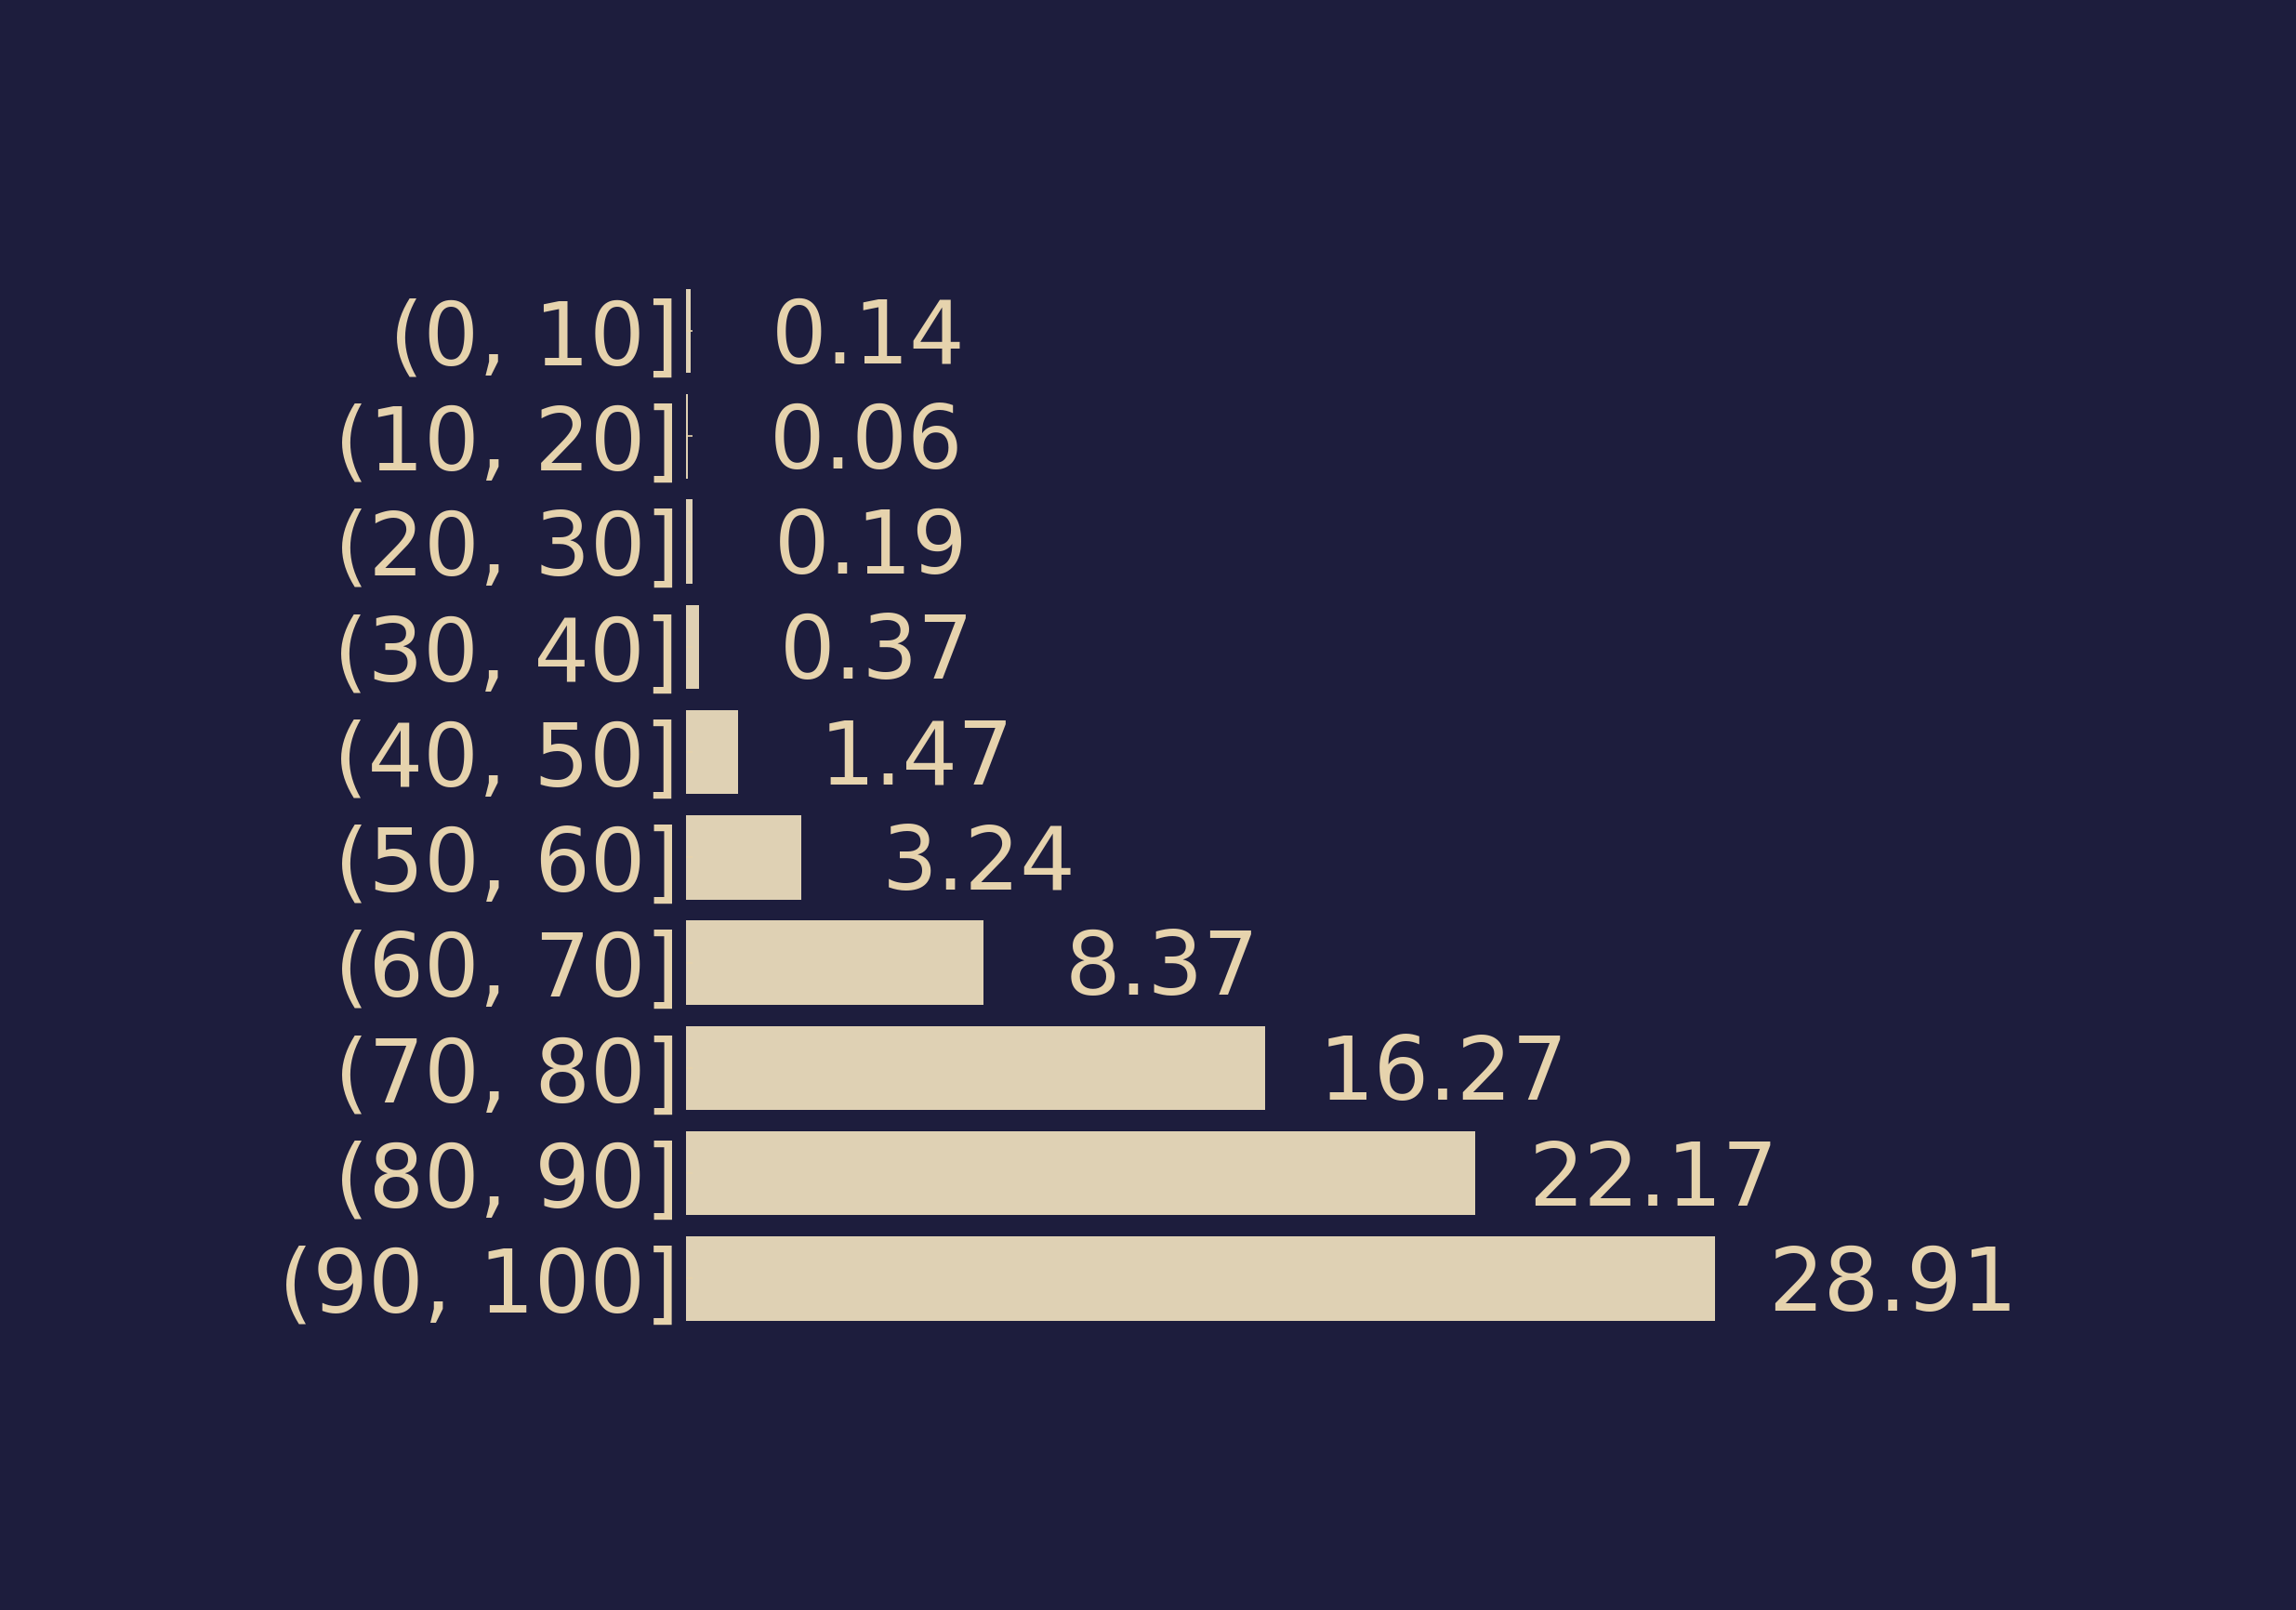

In [41]:
ax = sns.barplot(x="prob", y="edad", orient="h", data=compara_edades, color="#e6d3ad")

plt.grid(False)

ax.set_xlabel("", fontsize=30)
plt.xticks([])
plt.box(False)
ax.set_ylabel("", fontsize=30)

ax.tick_params(axis='y', colors='#e6d3ad')

# jugar con estos valores
vertical_offset = 0.3
horizontal_offset = 5

ax.tick_params(axis='both', which='major', labelsize=45)
for index, row in compara_edades.iterrows():
    ax.text(row["prob"] + horizontal_offset,index+vertical_offset, # posicion
            np.round(row["prob"], 2), # texto
            color='#e6d3ad', 
            ha="center", 
            size=45)
    
plt.savefig(f'probabilidades.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()